In [81]:
!pip install pyspark

In [ ]:
!pip install pydeequ

In [ ]:
!pip install findspark datasets tqdm prefect

In [84]:
!ls /usr/lib/jvm/java*

/usr/lib/jvm/java-1.11.0-openjdk-amd64:
bin  conf  docs  include  jmods  legal	lib  man  release

/usr/lib/jvm/java-11-openjdk-amd64:
bin  conf  docs  include  jmods  legal	lib  man  release


In [ ]:
!wget https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [85]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [86]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
os.environ['SPARK_VERSION'] = '3.5.1'
import pydeequ

In [112]:
spark = (SparkSession.builder
    .appName("DeduplicationQuality")
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate())

In [88]:
from pydeequ.checks import *
from pydeequ.verification import *

In [ ]:
!pip install datasets transformers  # Install necessary libraries


In [90]:
from datasets import load_dataset

In [114]:
dataset = load_dataset("SergGN/KStack_100k_pc")

In [115]:
pandas_df = dataset["train"].to_pandas()

In [116]:

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)
spark_df.show(5)

+--------------------+-----------+---------+-------+----------------------+--------------------+------+-------------+-----+-----+--------------------+----+---------------+------------------+
|                path|      owner|  repo_id|is_fork|languages_distribution|             content|issues|main_language|forks|stars|          commit_sha|size|           name|           license|
+--------------------+-----------+---------+-------+----------------------+--------------------+------+-------------+-----+-----+--------------------+----+---------------+------------------+
|app/src/main/kotl...| mtrewartha| 62930438|  false|                  NULL|package io.trewar...|   1.0|       Kotlin|    2|   18|63f1e5813ae535145...|  94|     positional|       MIT License|
|demo-app/src/main...|      0xera|746013123|  false|  {"Kotlin": 30604,...|package com.zero....|   0.0|       Kotlin|    0|    8|f1be77798e430e91c...| 704|     parcelable|       MIT License|
|app/src/main/kotl...|     openMF|133982000| 

In [93]:
spark_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- repo_id: long (nullable = true)
 |-- is_fork: boolean (nullable = true)
 |-- languages_distribution: string (nullable = true)
 |-- content: string (nullable = true)
 |-- issues: double (nullable = true)
 |-- main_language: string (nullable = true)
 |-- forks: long (nullable = true)
 |-- stars: long (nullable = true)
 |-- commit_sha: string (nullable = true)
 |-- size: long (nullable = true)
 |-- name: string (nullable = true)
 |-- license: string (nullable = true)



In [16]:
from pydeequ.analyzers import *
analysisResult = AnalysisRunner(spark) \
                    .onData(spark_df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Distinctness("owner")) \
                    .addAnalyzer(Completeness("content"))\
                    .addAnalyzer(Compliance("main_language_kotlin", "main_language == 'Kotlin'")) \
                    .addAnalyzer(Compliance("main_language_python", "main_language == 'Python'")) \
                    .addAnalyzer(Compliance("main_language_java", "main_language == 'Java'")) \
                    .run()

analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-------+--------------------+------------+--------------------+
| entity|            instance|        name|               value|
+-------+--------------------+------------+--------------------+
| Column|main_language_python|  Compliance|0.001126148772296...|
| Column|  main_language_java|  Compliance|0.050395157560279125|
| Column|             content|Completeness|                 1.0|
| Column|               owner|Distinctness|  0.3110684336477165|
| Column|main_language_kotlin|  Compliance|   0.876827478030044|
|Dataset|                   *|        Size|             99454.0|
+-------+--------------------+------------+--------------------+



/content/spark-3.5.3-bin-hadoop3/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


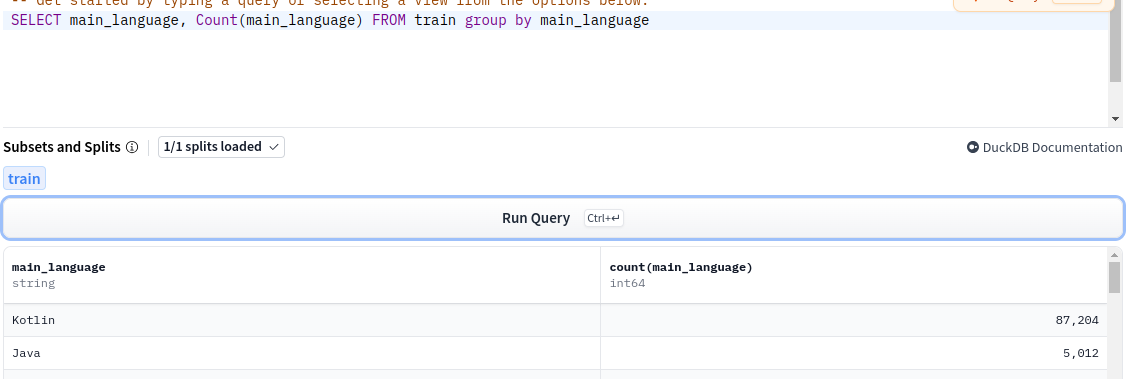

In [80]:
from pydeequ.suggestions import *

suggestionResult = ConstraintSuggestionRunner(spark) \
             .onData(spark_df) \
             .addConstraintRule(DEFAULT()) \
             .run()

# Constraint Suggestions in JSON format
print(json.dumps(suggestionResult, indent=2))

{
  "constraint_suggestions": [
    {
      "constraint_name": "CompletenessConstraint(Completeness(name,None,None))",
      "column_name": "name",
      "current_value": "Completeness: 1.0",
      "description": "'name' is not null",
      "suggesting_rule": "CompleteIfCompleteRule()",
      "rule_description": "If a column is complete in the sample, we suggest a NOT NULL constraint",
      "code_for_constraint": ".isComplete(\"name\")"
    },
    {
      "constraint_name": "CompletenessConstraint(Completeness(forks,None,None))",
      "column_name": "forks",
      "current_value": "Completeness: 1.0",
      "description": "'forks' is not null",
      "suggesting_rule": "CompleteIfCompleteRule()",
      "rule_description": "If a column is complete in the sample, we suggest a NOT NULL constraint",
      "code_for_constraint": ".isComplete(\"forks\")"
    },
    {
      "constraint_name": "ComplianceConstraint(Compliance('forks' has no negative values,forks >= 0,None,List(forks),None))"

In [94]:
from pydeequ.checks import *
from pydeequ.verification import *

verification_result = VerificationSuite(spark) \
    .onData(spark_df) \
    .addCheck( \
        Check(spark, CheckLevel.Warning, "Data Quality Checks") \
        .hasSize(lambda x: x > 0, "Dataset should not be empty") \
        .isComplete("path", "path should not be null") \
         .isContainedIn("main_language", ["Kotlin"], lambda x: x >= 0.8, "It should be above 0.8") \
         .isContainedIn("languages_distribution", ["Kotlin"]) \
        .isComplete("commit_sha") \
    ) \
    .run()

# Get and display results
check_result_df = VerificationResult.checkResultsAsDataFrame(spark, verification_result)
print("\nData Quality Verification Results:")
check_result_df.show(truncate=False)


Data Quality Verification Results:
+-------------------+-----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+--------------------------------------------------------------------+
|check              |check_level|check_status|constraint                                                                                                                                                                                    |constraint_status|constraint_message                                                  |
+-------------------+-----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----------------------------------------------------------

/content/spark-3.5.3-bin-hadoop3/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [118]:
# Lets specify DQ criteria
# Column description
#The dataset contains the following columns:
# size — size of the file in bytes  // > zero
# content — text (content) of the file after removing personal identifiable information // Not Null
# repo_id — GitHub ID of the repository // Not null (non uniq)
# path — path to a file in the repository // Not null
# owner — repo owner on GitHub    // Not null (but bot make sence for future ML usage in my opinion)
# name — repo name on GitHub      // not null
# commit_sha — hash of the commit, from which the revision of the file is taken //not null
# stars — number of stars in the repo at the moment of collection  //not null
# forks — number of forks in the repo at the moment of collection  //not null ()
# issues — number of issues in the repo at the moment of collection  //not null
# is_fork — true if the repo is a fork or not as defined by GitHub   //false/true statment
# main_language — main language of the repo as defined by GitHub    // *can be NULL
# languages_distribution — JSON with the distribution of languages by size in bytes in the repo
#                                                 // Can be NULL
# license — permissive license of the repository

#   The presence of the required Kotlin language in the dataset is a key indicator of quality.
#   >languages_distribution like '%Kotlin%' OR main_language ='Kotlin'
#
#
import pyspark.sql
# Register Temporary Table
spark_df.createOrReplaceTempView("temp")
# Select all data from temp table
spark.sql("select * from temp where languages_distribution not like '%Kotlin%' and main_language ='Kotlin'").show()


+--------------------+-------+---------+-------+----------------------+--------------------+------+-------------+-----+-----+--------------------+----+-----------+-----------+
|                path|  owner|  repo_id|is_fork|languages_distribution|             content|issues|main_language|forks|stars|          commit_sha|size|       name|    license|
+--------------------+-------+---------+-------+----------------------+--------------------+------+-------------+-----+-----+--------------------+----+-----------+-----------+
|src/main/java/al1...|tigerxp|228232024|   true|      {"Java": 209331}|package al132.alc...|   0.0|       Kotlin|    0|    0|651f2a84b1c5e556a...|1863|alchemistry|MIT License|
|src/main/kotlin/a...|tigerxp|228232024|   true|      {"Java": 209331}|package al132.alc...|   0.0|       Kotlin|    0|    0|ca6cd0b9b258291be...|8057|alchemistry|MIT License|
+--------------------+-------+---------+-------+----------------------+--------------------+------+-------------+-----+-

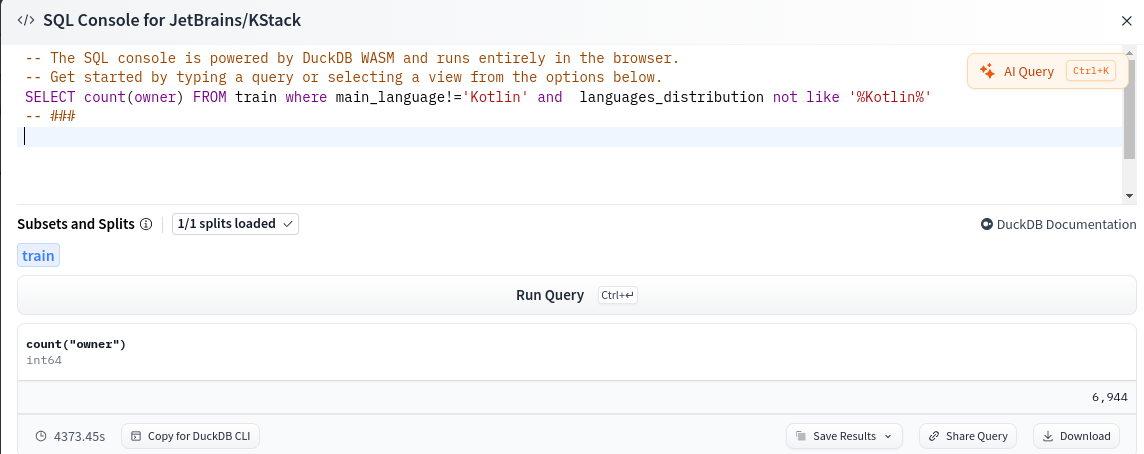

In [32]:
# from pydeequ.checks import Check
# from pydeequ.verification import VerificationSuite
# from pydeequ.scala_utils import ScalaFunction1, to_scala_seq
# # Prepare the check
# check = Check(spark, CheckLevel.Error, "GitHub Repository Data Quality Comprehensive Checks")

##   Not work version [Bug][Dependency][Blocked]Support Scala Deequ >= 2.0.4
#     169   in https://github.com/awslabs/python-deequ/issues/169

# https://pydeequ.readthedocs.io/_/downloads/en/latest/pdf/
# https://pydeequ.readthedocs.io/en/latest/pydeequ.html#pydeequ.checks.Check

In [80]:
""" |-- path: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- repo_id: long (nullable = true)
 |-- is_fork: boolean (nullable = true)
 |-- languages_distribution: string (nullable = true)
 |-- content: string (nullable = true)
 |-- issues: double (nullable = true)
 |-- main_language: string (nullable = true)
 |-- forks: long (nullable = true)
 |-- stars: long (nullable = true)
 |-- commit_sha: string (nullable = true)
 |-- size: long (nullable = true)
 |-- name: string (nullable = true)
 |-- license: string (nullable = true)"""

verification_result = VerificationSuite(spark) \
    .onData(spark_df) \
    .addCheck(
        Check(spark, CheckLevel.Warning, "Data Quality Checks")
        .hasSize(lambda x: x > 0, "Dataset should not be empty")
        .isComplete("path", "path should be not null")
        .isComplete("owner", "owner should be not null")
        .isComplete("repo_id", "repo_id should be not null")
        .isComplete("is_fork", "is_fork (boolean) should not be null")
        .hasDataType("is_fork", ConstrainableDataTypes.Boolean,  lambda x: x in [True] , "is_fork should be boolean")
        .isComplete("issues", "issues should not be null")
        .isComplete("forks", "forks should not be null")
        .isComplete("stars", "stars should not be null")
        .isComplete("commit_sha", "commit_sha should not be null")
        .isComplete("size", "size should not be null")
        .isComplete("name", "name should not be null")
        .isContainedIn("main_language", ["Kotlin"], lambda x: x >= 0.8, "main_language should be above 0.8")
        #.isContainedIn(["main_language","languages_distribution"], ["Kotlin"], lambda x: x >= 0.8, "It should be above 0.8")
        .haveAnyCompleteness(["main_language","languages_distribution"], lambda x: x >= 0.8, "Kotlin must be in main lang field or languages_distribution")

        .hasPattern("commit_sha", r"^[a-fA-F0-9]{40}$", lambda x: x in [True], "Commit SHA must be 40 characters long and hexadecimal")
        .hasPattern("content", r"\S+", lambda x: x in [True] ,"Content should not be empty after trimming")\

    ) \
    .run()

check_result_df = VerificationResult.checkResultsAsDataFrame(spark, verification_result)
print("DQ Verification Results:")
check_result_df.show(50,truncate=False)

DQ Verification Results:
+-------------------+-----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+
|check              |check_level|check_status|constraint                                                                                                                                                                    |constraint_status|constraint_message|
+-------------------+-----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+
|Data Quality Checks|Warning    |Success     |SizeConstraint(Size(None))                                                                                                                              

/content/spark-3.5.3-bin-hadoop3/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [66]:
# DQ Verification included minimal checks  by isComplete and hasDataType method
# Checks SHA and Content as example re finc
# Validation main_language is Kotlin in 80%
# Validation main_language or languages_distribution should contains Kotlin  (main_language or languages_distribution)

In [104]:
!prefect server start &


 ___ ___ ___ ___ ___ ___ _____ 
| _ \ _ \ __| __| __/ __|_   _| 
|  _/   / _|| _|| _| (__  | |  
|_| |_|_\___|_| |___\___| |_|  

Configure Prefect to communicate with the server with:

    prefect config set PREFECT_API_URL=http://127.0.0.1:4200/api

View the API reference documentation at http://127.0.0.1:4200/docs

Check out the dashboard at http://127.0.0.1:4200



Received SIGINT. Sending SIGTERM to the Prefect server (PID 79730)...
Server stopped!


In [ ]:
!pip install datasketch huggingface-hub dpu-utils prefect

In [121]:
import json
import multiprocessing as mp
import re
from collections import defaultdict
from functools import partial
from typing import Dict, List, Optional, Set, Tuple, Type


from datasets import Dataset, load_dataset
from tqdm import tqdm
from datasketch import MinHash, MinHashLSH
from dpu_utils.utils.iterators import ThreadedIterator

import pydeequ #pip install git+https://github.com/awslabs/python-deequ.git
from pydeequ.analyzers import *
from pydeequ.checks import *
from pydeequ.verification import *
from pydeequ.suggestions import *

# Add these to your existing imports
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# Constants
NON_ALPHA = re.compile("[^A-Za-z_0-9]")
MIN_NUM_TOKENS = 10
NUM_PERM = 256
PATH_COLUMN = "path"
CONTENT = "content"

# Dataset Configuration Constants
HF_SOURCE_DATASET = "JetBrains/KStack"  # Hugging Face source dataset
DATASET_SIZE_LIMIT = 10000  # Limit dataset size for testing/resource management
JACCARD_THRESHOLD = 0.85  # Jaccard similarity threshold
OUTPUT_DATASET_PATH = "./data/data-near-dedup"  # Local output path
HF_REPO_NAME = "JB_KStack_near_dedup_100k"  # Repository name for upload
HF_ORG = "SergGN"  # Organization or username for HF upload
TEST_SAMPLE_SIZE = 7000  # Size for test runs

#@task(name="prepare_dataset", retries=2)
def prepare_dataset(
    dataset_name: str,
    size_limit: int = DATASET_SIZE_LIMIT,
    test_run: bool = False
) -> Dataset:
    """
    Load and prepare dataset with size limitations

    Args:
        dataset_name: Name of the dataset in Hugging Face hub
        size_limit: Maximum number of samples to process
        test_run: If True, uses a very small subset for testing
    """
    ds = load_dataset(dataset_name, split="train")

    if test_run:
        ds = ds.select(range(min(TEST_SAMPLE_SIZE, len(ds))))
    elif size_limit:
        ds = ds.select(range(min(size_limit, len(ds))))

    print(f"Prepared dataset size: {len(ds)}")
    return ds

#@task(name="make_duplicate_clusters")
def make_duplicate_clusters(dataset: Dataset, jaccard_threshold: float) -> List[List[Dict]]:
    """Find duplicate clusters in the dataset"""
    print("Starting duplicate cluster creation")
    duplication_index = DuplicationIndex(jaccard_threshold)

    # Process each item in the dataset
    for idx in tqdm(range(len(dataset)), desc="Processing items"):
        try:
            content = dataset[idx][CONTENT]
            path = dataset[idx][PATH_COLUMN]

            # Create MinHash
            tokens = [t for t in NON_ALPHA.split(content) if len(t.strip()) > 0]
            if len(tokens) < MIN_NUM_TOKENS:
                continue

            minhash = MinHash(num_perm=NUM_PERM)
            for token in tokens:
                minhash.update(token.encode('utf-8'))

            duplication_index.add((idx, path), minhash)

        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            continue

    return duplication_index.get_duplicate_clusters()

class DuplicationIndex:
    """Wrapper class for MinHashLSH operations"""
    def __init__(self, jaccard_threshold: float = JACCARD_THRESHOLD):
        self._duplication_jaccard_threshold = jaccard_threshold
        self._num_perm = NUM_PERM
        self._index = MinHashLSH(
            threshold=self._duplication_jaccard_threshold,
            num_perm=self._num_perm
        )
        self._duplicate_clusters = defaultdict(set)

    def add(self, code_key: Tuple, min_hash: MinHash) -> None:
        close_duplicates = self._index.query(min_hash)
        if code_key in self._index.keys:
            return

        self._index.insert(code_key, min_hash)
        if close_duplicates:
            for base_duplicate in close_duplicates:
                if base_duplicate in self._duplicate_clusters:
                    self._duplicate_clusters[base_duplicate].add(code_key)
                    break
            else:
                self._duplicate_clusters[close_duplicates[0]].add(code_key)

    def get_duplicate_clusters(self) -> List[List[Dict]]:
        duplicate_clusters = []
        for base, duplicates in self._duplicate_clusters.items():
            cluster = [base] + list(duplicates)
            cluster = [{"base_index": el[0], "path": el[1]} for el in cluster]
            duplicate_clusters.append(cluster)
        return duplicate_clusters

#@task(name="process_extremes")
def process_extremes(
    duplicate_clusters: List[List[Dict]],
    dataset: Dataset,
    jaccard_threshold: float
) -> List[List[Dict]]:
    """Process clusters to find extremes"""
    extremes_list = []

    for cluster in tqdm(duplicate_clusters, desc="Processing clusters"):
        extremes = find_cluster_extremes(cluster, dataset, jaccard_threshold)
        extremes_list.append(extremes)

    return extremes_list

def find_cluster_extremes(
    cluster: List[Dict],
    dataset: Dataset,
    jaccard_threshold: float
) -> List[Dict]:
    """Find reduced cluster representation"""
    extremes = []
    for element1 in cluster:
        code1 = dataset[element1["base_index"]][CONTENT]
        for element2 in extremes:
            code2 = dataset[element2["base_index"]][CONTENT]
            tokens1 = set([t for t in NON_ALPHA.split(code1) if len(t.strip()) > 0])
            tokens2 = set([t for t in NON_ALPHA.split(code2) if len(t.strip()) > 0])
            similarity = len(tokens1 & tokens2) / len(tokens1 | tokens2)
            if similarity >= jaccard_threshold:
                element2["copies"] += 1
                break
        else:
            element1["copies"] = 1
            extremes.append(element1)
    return extremes

#@task(name="setup_spark")
def setup_spark() -> SparkSession:
    """Initialize Spark session with PyDeequ configuration"""
    spark = (SparkSession
        .builder
        .config("spark.jars.packages", pydeequ.deequ_maven_coord)
        .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
        .getOrCreate())
    return spark

#@task(name="verify_data_quality")
def verify_data_quality(dataset: Dataset, spark: SparkSession) -> bool:
    """Verify data quality using PyDeequ"""
    # # Convert Dataset to Spark DataFrame
    # schema = StructType([
    #     StructField(CONTENT, StringType(), True),
    #     StructField(PATH_COLUMN, StringType(), True)
    # ])

    df = spark.createDataFrame(
        dataset.to_pandas()
        #,schema=schema
    )

    # Define checks
    check = Check(spark, CheckLevel.Error, "Data Quality Check")

    verification_result = VerificationSuite(spark) \
    .onData(df) \
    .addCheck(
        Check(spark, CheckLevel.Warning, "Data Quality Checks")
        .hasSize(lambda x: x > 0, "Dataset should not be empty")
        .isComplete("path", "path should be not null")
        .isComplete("owner", "owner should be not null")
        .isComplete("repo_id", "repo_id should be not null")
        .isComplete("is_fork", "is_fork (boolean) should not be null")
        .hasDataType("is_fork", ConstrainableDataTypes.Boolean,  lambda x: x in [True] , "is_fork should be boolean")
        .isComplete("issues", "issues should not be null")
        .isComplete("forks", "forks should not be null")
        .isComplete("stars", "stars should not be null")
        .isComplete("commit_sha", "commit_sha should not be null")
        .isComplete("size", "size should not be null")
        .isComplete("name", "name should not be null")
        .isContainedIn("main_language", ["Kotlin"], lambda x: x >= 0.8, "main_language should be above 0.8")
        #.isContainedIn(["main_language","languages_distribution"], ["Kotlin"], lambda x: x >= 0.8, "It should be above 0.8")
        .haveAnyCompleteness(["main_language","languages_distribution"], lambda x: x >= 0.8, "Kotlin must be in main lang field or languages_distribution")

        .hasPattern("commit_sha", r"^[a-fA-F0-9]{40}$", lambda x: x in [True], "Commit SHA must be 40 characters long and hexadecimal")
        .hasPattern("content", r"\S+", lambda x: x in [True] ,"Content should not be empty after trimming")\

    ) \
    .run()


    # Print verification results
    verification_df = VerificationResult.checkResultsAsDataFrame(spark, verification_result)
    print("\nData Quality Verification Results:")
    verification_df.show()

    # Return True if all checks passed
    return verification_result.status == "Success"

#@flow(name="Near-Deduplication")
def deduplicate_dataset_flow(
    dataset_name: str = HF_SOURCE_DATASET,
    size_limit: int = DATASET_SIZE_LIMIT,
    jaccard_threshold: float = JACCARD_THRESHOLD,
    test_run: bool = False
) -> Tuple[Dataset, List[List[Dict]]]:

    """Main flow for dataset deduplication with data quality checks"""
    # Setup Spark
    spark = setup_spark()

    try:
        # Prepare dataset
        dataset = prepare_dataset(
            dataset_name=dataset_name,
            size_limit=size_limit,
            test_run=test_run
        )

        # Verify data quality
        quality_check_passed = verify_data_quality(dataset, spark)
        if not quality_check_passed:
            print("Data quality checks failed. Please review the verification results.")

        # Continue with existing deduplication logic
        duplicate_clusters = make_duplicate_clusters(dataset, jaccard_threshold)

        # Get all duplicate indices
        duplicate_indices = set(
            x["base_index"] for cluster in duplicate_clusters for x in cluster
        )

        # Process extremes
        extremes_clusters = process_extremes(duplicate_clusters, dataset, jaccard_threshold)

        # Build extreme dictionary
        extreme_dict = {}
        for extremes in extremes_clusters:
            for element in extremes:
                extreme_dict[element["base_index"]] = element

        # Filter dataset
        remove_indices = duplicate_indices - set(extreme_dict.keys())
        ds_filter = dataset.filter(
            lambda x, idx: idx not in remove_indices,
            with_indices=True
        )

        # Update duplicate clusters
        for cluster in duplicate_clusters:
            for element in cluster:
                element["is_extreme"] = element["base_index"] in extreme_dict
                if element["is_extreme"]:
                    element["copies"] = extreme_dict[element["base_index"]]["copies"]

        return ds_filter, duplicate_clusters

    finally:
        # Clean up Spark session
        print("как бы стоп ")
        ##spark.stop()


dedup_ds, clusters = deduplicate_dataset_flow(
    dataset_name=HF_SOURCE_DATASET,
    size_limit=DATASET_SIZE_LIMIT
)

print(f"Final deduplicated dataset size: {len(dedup_ds)}")
print(f"Number of duplicate clusters: {len(clusters)}")

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

Prepared dataset size: 10000


/content/spark-3.5.3-bin-hadoop3/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



Data Quality Verification Results:
+-------------------+-----------+------------+--------------------+-----------------+------------------+
|              check|check_level|check_status|          constraint|constraint_status|constraint_message|
+-------------------+-----------+------------+--------------------+-----------------+------------------+
|Data Quality Checks|    Warning|     Success|SizeConstraint(Si...|          Success|                  |
|Data Quality Checks|    Warning|     Success|CompletenessConst...|          Success|                  |
|Data Quality Checks|    Warning|     Success|CompletenessConst...|          Success|                  |
|Data Quality Checks|    Warning|     Success|CompletenessConst...|          Success|                  |
|Data Quality Checks|    Warning|     Success|CompletenessConst...|          Success|                  |
|Data Quality Checks|    Warning|     Success|AnalysisBasedCons...|          Success|                  |
|Data Quality Check

Processing clusters: 100%|██████████| 18/18 [00:00<00:00, 240.70it/s]

как бы стоп 
Final deduplicated dataset size: 9969
Number of duplicate clusters: 18
